Step1. Import Module

Step2. Check Device

Step3. Download CIFAR10 Data

Step4. Check Data

Step5. Check Data

Step6. ResNet Model 

Step7. Optimizer, Objective Function

Step8. Check Train data's Loss

Step8. Check Vaild data's Loss

Step9. Check Test set Accuracy 

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn               #pytorch module 중 인공신경망 설계할때 필요한 함수
import torch.nn.functional as F     #nn중에서도 자주 이용되는 함수 F
from torchvision import transforms, datasets 

In [22]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else : 
    DEVICE = torch.device('cpu')
    
print('Using Pytorch version : ', torch.__version__, 'Device :', DEVICE)

Using Pytorch version :  1.9.1 Device : cpu


In [23]:
BATCH_SIZE = 32                      #Iteration = 전체데이터개수 / batch_size , back propagation을 진행하는 단위
EPOCHS = 10                          #Epochs는 존재하고 있는 Mini_batch를 전부 이용하는 횟수를 의미

In [24]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,                   #인터넷에서 다운로드
                                 transform = transforms.ToTensor()) #transforms으로 0~255, -> 0~1로 정규화
test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = False,
                                 transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [25]:
for (X_train, y_train) in train_loader:
    print('X_train :', X_train.size(),'type : ', X_train.type())
    print('y_train :', y_train.size(),'type :', y_train.type())
    break

X_train : torch.Size([32, 3, 32, 32]) type :  torch.FloatTensor
y_train : torch.Size([32]) type : torch.LongTensor


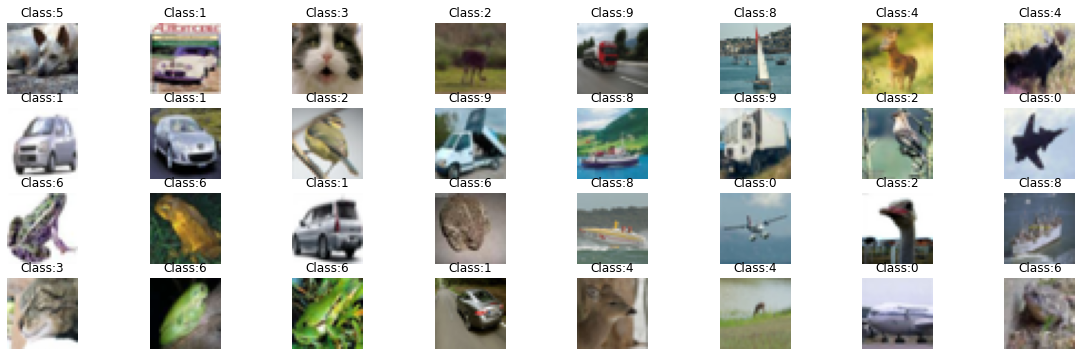

In [26]:
pltsize = 2
plt.figure(figsize=(10*pltsize, 3*pltsize))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0))) #X_train[i]([channel],[height],[width]) --> X_train[i]([width],[height],[channel])
    plt.title('Class:'+ str(y_train[i].item()))

In [59]:
class BasicBlock(nn.Module): #반복적으로 이용하는 block
    def __init__(self, in_planes, planes, stride =1 ):  #in_planes : input으로 정의되는 채널의 수
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 
                              kernel_size = 3,   #필터의 크기
                              stride = stride,
                              padding = 1,
                              bias = False) #bias값을 더해줄건지 선택하는 옵션
        self.bn1 = nn.BatchNorm2d(planes) #각 Layers 마다 Input의 분포가 달라지기때문에 학습속도가 현저히 느려지는 것을 방지
        self.conv2 = nn.Conv2d(planes, planes,
                              kernel_size = 3,
                              stride = 1,
                              padding =1, 
                              bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()       #기존값과 convolution 및 batch normalization한 결과를 더하는 과정을 의미합니다.
        if stride !=1 or in_planes !=planes: # stride가 1이 아니거나 in_planes가 1이 아니거나 == 두번째 블록부터 적용하겠다.
            self.shortcut = nn.Sequential(     
                nn.Conv2d(in_planes, planes, 
                         kernel_size = 1,
                         stride = stride,
                         bias = False),
                nn.BatchNorm2d(planes))
            
    def forward(self, x):                    
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out +=self.shortcut(x) #skip connetion과정 : residual block을 이용해 깊은 신경망을 만들 때 생기는 vanishing gradient문제 해결
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
    
        
        self.conv1 = nn.Conv2d(3, 16, 
                              kernel_size = 3,
                              stride =1,
                              padding =1,
                              bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16,2,stride =1)
        self.layer2 = self._make_layer(32,2,stride =2)
        self.layer3 = self._make_layer(64,2,stride =2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks -1)
        layers = []
        for stride in strides :
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out,8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [60]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [61]:
#학습데이터에 대한 모델 성능
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #zero로 초기화
        output = model(image)
        loss = criterion(output, label) #cross entropy로 loss값계산
        loss.backward() #계산된 loss값으로 back propagation을 통해 계산된 gradient값을 각 파라미터에 할당
        optimizer.step() #각 파라미터별로 할당된 gradient 값을 이용해 파라미터 값을 업데이트합니다
        
        if batch_idx % log_interval == 0 :
            print("Train Epochs : {} [{}/{}({:.0f}%)]|tTrain Loss: {:.6f}".format(
                Epoch, batch_idx*len(image),
                len(train_loader.dataset), 100.*batch_idx / len(train_loader),
                loss.item()))

In [62]:
#검증데이터에 대한 모델 성능
def evaluate(model, test_loader):
    model.eval()            #model을 평가상태로 바꾸기
    test_loss = 0       
    correct = 0
    with torch.no_grad():  #평가단계에 gradient 학습방지
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]   #제일큰확률찾기
            correct += prediction.eq(label.view_as(prediction)).sum().item() #올바르게 예측한 수 세기
    test_loss /= len(test_loader.dataset)  #test_loss(평균loss) = 지금까지계산된loss/minibatch개수
    test_accuracy = 100. * correct / len(test_loader.dataset) # 100* (올바르게 예측한 개수/minibatch개수)
    return test_loss, test_accuracy

In [63]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("/n[EPOCH:{}], /tTest Loss : {:.4f}, /tTest Accuracy: {:.2f} % /n".
         format(Epoch, test_loss, test_accuracy))

Train Epochs : 1 [0/50000(0%)]|tTrain Loss: 2.350781
Train Epochs : 1 [6400/50000(13%)]|tTrain Loss: 1.472266
Train Epochs : 1 [12800/50000(26%)]|tTrain Loss: 1.582250
Train Epochs : 1 [19200/50000(38%)]|tTrain Loss: 1.035846
Train Epochs : 1 [25600/50000(51%)]|tTrain Loss: 1.153473
Train Epochs : 1 [32000/50000(64%)]|tTrain Loss: 1.437962
Train Epochs : 1 [38400/50000(77%)]|tTrain Loss: 1.314770
Train Epochs : 1 [44800/50000(90%)]|tTrain Loss: 1.037832
/n[EPOCH:1], /tTest Loss : 0.0336, /tTest Accuracy: 61.23 % /n
Train Epochs : 2 [0/50000(0%)]|tTrain Loss: 0.814311
Train Epochs : 2 [6400/50000(13%)]|tTrain Loss: 0.939717
Train Epochs : 2 [12800/50000(26%)]|tTrain Loss: 0.927264
Train Epochs : 2 [19200/50000(38%)]|tTrain Loss: 0.962593
Train Epochs : 2 [25600/50000(51%)]|tTrain Loss: 1.205168
Train Epochs : 2 [32000/50000(64%)]|tTrain Loss: 0.915435
Train Epochs : 2 [38400/50000(77%)]|tTrain Loss: 0.816250
Train Epochs : 2 [44800/50000(90%)]|tTrain Loss: 0.816779
/n[EPOCH:2], /tTest L